In [1]:
# Preamble
from astropy.table import Table, column
import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

import sys
sys.path.append('../../astro_codes/')

In [2]:
gz2_data = Table.read('../../fits/full_sample_debiased_w_low_z.fits')

In [3]:
sparcfire = Table.read('../../fits/sparcfire/pitch_angles.fits')
sparcfire_samples = Table.read('../../fits/sparcfire/sparcfire_samples.fits')
g_ok = Table.read('../g_vs_r/g_ok.fits')

In [17]:
import pandas as pd
sparcfire_g_arcs = pd.read_csv('../../sparcfire_directories/g/g.galaxy_arcs.csv') # individual arc data

In [6]:
sparcfire_g = Table.read('../../sparcfire_directories/g/g.galaxy_matched.fits') # sparcfire data
sparcfire_r = Table.read('../../sparcfire_directories/r/r.galaxy_matched.fits')

In [7]:
in_spiral = np.all([sparcfire_samples['in_spiral'],sparcfire_samples['in_mass_limit'],
                    sparcfire_samples['axial_ok']],axis=0)
print('{} spirals!'.format(in_spiral.sum()))
in_sparcfire = np.all([sparcfire_g['fit_state'] == 'OK',g_ok['ok'],
                       sparcfire_r['fit_state'] == 'OK'],axis=0)

spiral_sample = (in_spiral*in_sparcfire).astype(bool)

print('--> {} in sparcfire g+r (w. correct image sizes now!!)'.format(spiral_sample.sum()))

4020 spirals!
--> 2671 in sparcfire g+r (w. correct image sizes now!!)


In [35]:
'''
in_sample = np.all([samples['in_spiral'],samples['axial_ok'],
                    mendel_masses['in_mass_limit'],sparcfire['P']>0,
                    in_sparcfire_r],
                   axis=0)

print('{} spiral galaxies!'.format(in_sample.sum()))

N_required = 500

spiral_range = np.arange(in_sample.sum())
np.random.seed(0)
spiral_indices = np.random.choice(spiral_range,N_required,replace=False)

gz_spirals = gz_data[in_sample]
dr7ids = gz_spirals['dr7objid_1'][spiral_indices]
dr8ids = gz_spirals['dr8objid'][spiral_indices]
urls = gz_spirals['jpeg_url'][spiral_indices]
spiral_table = Table(np.array([dr7ids,dr8ids,urls]).T,
                     names=('dr7id','dr8id','url'),
                     dtype=('int64','int64','str'))

#spiral_table.write('spiral_ids.fits',overwrite=True)
'''
#spiral_table = Table.read('spiral_ids.fits')

N_required = 500

all_indices = np.arange(len(gz2_data))
spiral_indices = all_indices[spiral_sample]
np.random.seed(0)
subset_indices = np.random.choice(spiral_indices,N_required,replace=False)
dr7ids = gz2_data['dr7objid_1'][subset_indices]
dr8ids = gz2_data['dr8objid'][subset_indices]
urls = gz2_data['jpeg_url'][subset_indices]
spiral_table = Table(np.array([dr7ids,dr8ids,urls]).T,
                     names=('dr7id','dr8id','url'),
                     dtype=('int64','int64','str'))

spiral_table.write('panoptes_images/spiral_table.fits',overwrite=True)

In [28]:
from paramiko import SSHClient
from scp import SCPClient

ssh = SSHClient()
ssh.load_system_host_keys()
ssh.connect('bayonet-08.ics.uci.edu',username='zoo',password='GalaxyZoo2')
scp = SCPClient(ssh.get_transport())
ftp = ssh.open_sftp()
#files = ftp.listdir()

In [29]:
import matplotlib.image as mpimg
import matplotlib.patheffects as path_effects

class ArcImage():
    
    def __init__(self,dr8id,ssh,scp,ftp,band='r',save_directory='save_images'):
        self.dr8id = int(dr8id)
        self.band = band
        self.id_string = str(dr8id)
        self.id_suffix = self.id_string[-3:]
        self.remote_directory = ('/home/zoo/SpArcFiRe/SpArcFiRe/'
                                 '{}/{}/{}'.format(self.band,self.id_suffix,self.id_string))
        self.band_directory = '{}/{}'.format(save_directory,self.band)
        self.galaxy_directory = '{}/{}/{}'.format(save_directory,self.band,self.id_string)
        if os.path.isdir(save_directory) is False:
            os.mkdir(save_directory)
        if os.path.isdir(self.band_directory) is False:
            os.mkdir(self.band_directory)
        if os.path.isdir(self.galaxy_directory) is False:
            os.mkdir(self.galaxy_directory)
        self.ssh = ssh
        self.scp = scp
        self.ftp = ftp
    
    def download_remote_files(self,overwrite=False):
        file_list = self.ftp.listdir(self.remote_directory)
        for file in file_list:
            remote_file = '{}/{}'.format(self.remote_directory,file)
            local_file = '{}/{}'.format(self.galaxy_directory,file)
            if (os.path.exists(local_file)) is True:
                    os.remove(local_file) if overwrite is True else None
            if (os.path.exists(local_file)) is False:
                self.scp.get(remote_file,local_file)
        return None
    
    def download_remote_figure(self,overwrite=False,suffix='B_autoCrop'):
        file = '{}-{}.png'.format(self.id_string,suffix)
        remote_file = '{}/{}'.format(self.remote_directory,file)
        local_file = '{}/{}'.format(self.galaxy_directory,file)
        if (os.path.exists(local_file)) is True:
                os.remove(local_file) if overwrite is True else None
        if (os.path.exists(local_file)) is False:
                self.scp.get(remote_file,local_file)
        return None
    
    def arc_parameters(self,arc_file,N_max=8):
        row_mask = arc_file['gxyName'] == self.dr8id
        arcs = arc_file[row_mask].sort_values('alenRank')
        arc_table = Table(arcs.as_matrix(),names=arcs.dtypes.index)
        if len(arc_table) > N_max:
            arc_table = arc_table[:N_max]
        return arc_table
    
    def galaxy_parameters(self,galaxy_file):
        row_mask = galaxy_file['name'] == self.dr8id
        galaxy_table = galaxy_file[row_mask]
        return galaxy_table
    
    def display_image(self,ax,suffix='B_autoCrop'):
        _ = self.download_remote_figure(overwrite=False,suffix=suffix)
        image_file = '{}/{}-{}.png'.format(self.galaxy_directory,self.id_string,suffix)
        image = mpimg.imread(image_file)
        h, w = image.shape
        ax.imshow(image,cmap='gray')
        ax.set_xlim(0,w-1)
        ax.set_ylim(h-1,0)
        ax.set_xticks([])
        ax.set_yticks([])
        return h, w
     
    def draw_arcs(self,ax,arc_file,label=True,
                  **kwargs):
        plt.sca(ax)
        colors = ('red','blue','orange','magenta',
                  'limegreen','orangered','purple','cyan')
        arc_table = self.arc_parameters(arc_file,N_max=8)
        N_arcs = len(arc_table)
        for n in range(N_arcs):
            arc_row = arc_table[n]
            theta_start = arc_row['math_initial_theta']
            theta_end = theta_start + arc_row['relative_theta_end']
            psi = arc_row['pitch_angle']*(2*math.pi/360)
            initial_radius = arc_row['math_initial_radius']
            r0 = initial_radius/np.exp(-psi*theta_start)
            thetas = np.linspace(theta_start,theta_end,1000)
            x = r0*(np.cos(thetas))*np.exp(-psi*thetas)#+128
            y = r0*(np.sin(thetas))*np.exp(-psi*thetas)#+128
            x_transformed = x + 128
            y_transformed = -y + 128
            ax.plot(x_transformed,y_transformed,
                     color=colors[n],**kwargs)
            if label is True:
                x_centre, y_centre = x_transformed[500], y_transformed[500]
                #x_centre = x_centre+5 if x_centre < 128 else x_centre-5
                y_centre = y_centre+8 if y_centre < 20 else y_centre-8
                text = plt.text(x_centre,y_centre,'{}'.format(n+1),
                                color=colors[n])
                text.set_weight('heavy')
                text.set_size(30)
                text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='white'),
                                       path_effects.Normal()])
            
        return None
    
    def draw_ellipse(self,ax,galaxy_file,h,w,**kwargs):
        galaxy_parameters = self.galaxy_parameters(galaxy_file)
        a = galaxy_parameters['diskMajAxsLen']/2
        b = galaxy_parameters['diskMinAxsLen']/2
        theta_major = galaxy_parameters['diskMajAxsAngleRadians']
        thetas = np.linspace(0,2*math.pi,1000)
        r = (a*b)/np.sqrt((b*np.cos(thetas-theta_major))**2+(a*np.sin(thetas-theta_major))**2)
        x = r*np.cos(thetas)
        y = r*np.sin(thetas)
        plt.plot(x+w/2,-y+h/2,**kwargs)
        return None
    
    def get_arcs(id_,arc_data,galaxy_data,N_arcs=8):
        arc_rows = arc_data[arc_data['gxyName'] == id_].sort_values('alenRank')
        galaxy_row = galaxy_data[galaxy_data['name'] == id_]
        galaxy_chirality = galaxy_row['chirality_wtdPangSum'][0]
        if len(arc_rows > N_arcs):
            arc_rows = arc_rows[:N_arcs]
    
        empty_frame = pd.DataFrame()
        if galaxy_chirality is 'Swise':
            empty_frame['chirality_agreement'] = arc_rows['pitch_angle'] >= 0
        else:
            empty_frame['chirality_agreement'] = arc_rows['pitch_angle'] < 0
        empty_frame['length'] = arc_rows['arc_length']
        empty_frame['pitch_angle'] = np.absolute(arc_rows['pitch_angle'])
        empty_frame['delta_r'] = np.absolute(arc_rows['r_start'] - arc_rows['r_end'])
        empty_frame['r_start'] = arc_rows['r_start']
        empty_frame['r_end'] = arc_rows['r_end']
        empty_frame['delta_theta'] = arc_rows['relative_theta_end']
        empty_frame['N_pixels'] = arc_rows['num_pixels']
    return empty_frame

# List of image suffixes: #
##########################
# A_input
# B_autoCrop
# C_preproc
# D_clusMask
# E_hacArcs
# F_logSpiralArcs
# G_imgClusters-merged
# H_clusMask-merged
# I_hacArcs-merged
# J_logSpiralArcs-merged
# K_clusMask-reprojected
# O_orientation-field
##########################

In [37]:
#id_ = spiral_table['dr8id'][0]
dr8ids = spiral_table['dr8id']
fig = plt.figure(figsize=(10,10))

for id_ in dr8ids:
    ax = plt.subplot(111)
    a = ArcImage(id_,ssh,scp,ftp,band='g')
    #a.download_remote_figure()
    #a.display_image(ax,'C_preproc')
    a.display_image(ax,'B_autoCrop')
    fig.savefig('panoptes_images/{}.png'.format(id_),dpi=200)
    a.draw_arcs(ax,sparcfire_g_arcs)
    fig.savefig('panoptes_images/{}+arcs.png'.format(id_),dpi=200)
    fig.clf()

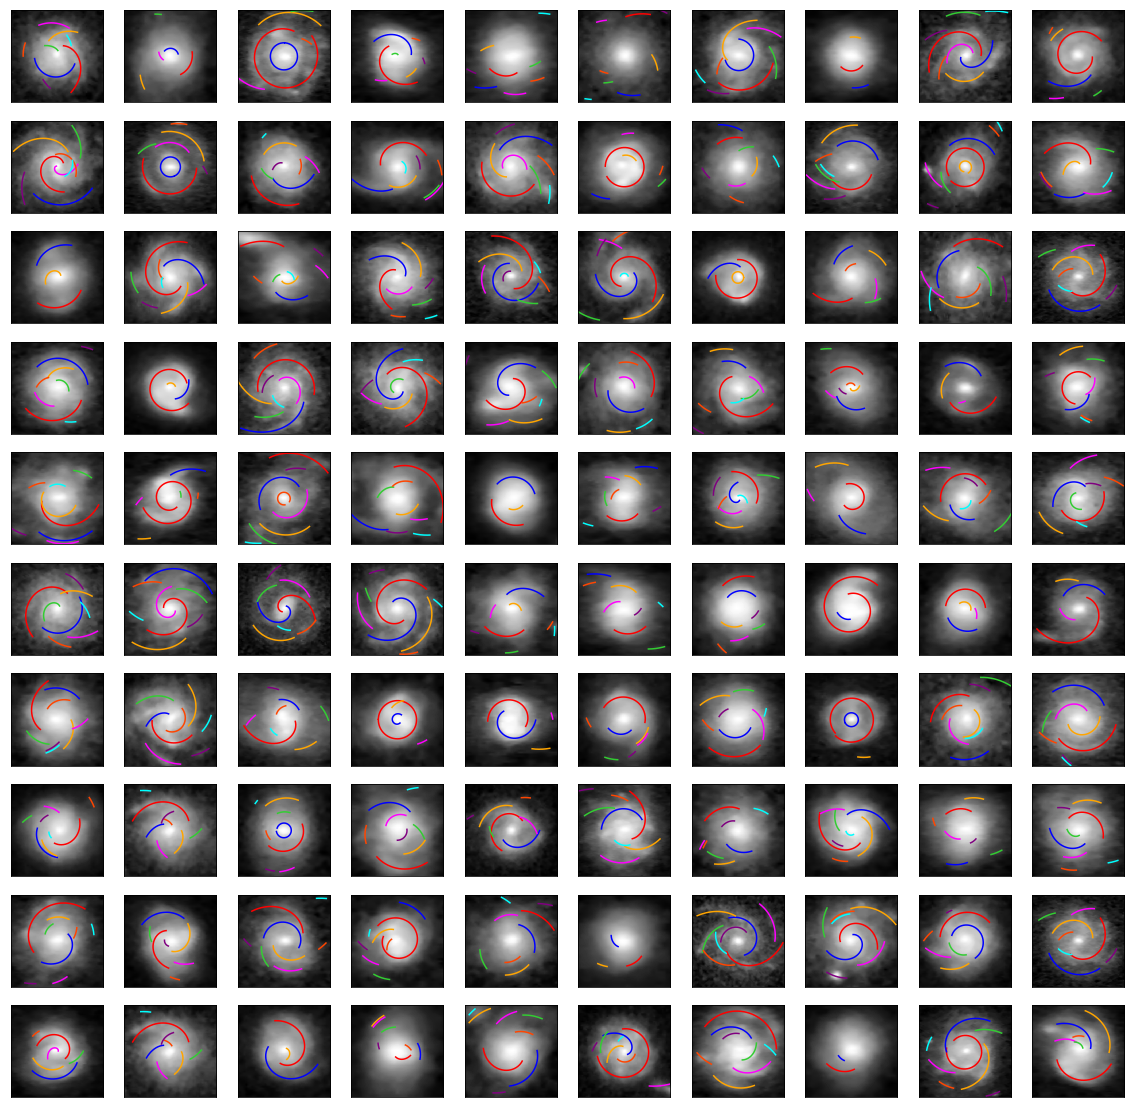

In [25]:
fig, axarr = plt.subplots(10,10,figsize=(20,20))
axarr = axarr.ravel()
#ids = spiral_table['dr8id']

for i, id_ in enumerate(dr8ids[400:500]):
    ax = axarr[i]
    a = ArcImage(id_,ssh,scp,ftp,band='g')
    a.display_image(ax,'B_autoCrop')
    a.draw_arcs(ax,sparcfire_g_arcs,label=False)

In [ ]:
bad_ids = dr8ids[2:5]
#ArcImage(id0,ssh,scp,ftp).galaxy_level_params(sparcfire_r)

def get_bad_galaxy(dr8id):
    g_in, g_cropped, g_out = ArcImage(dr8id,ssh,scp,ftp,band='g').download_remote_files()
    r_in, r_cropped, r_out = ArcImage(dr8id,ssh,scp,ftp,band='r').download_remote_files()
    image_files = [g_in, g_cropped, g_out, r_in, r_cropped, r_out]
    labels = ['g input','g cropped','g output', 'r input','r cropped','r output']
    fig, axarr = plt.subplots(1,6,figsize=(20,3.3))
    for a, ax in enumerate(axarr):
        image = mpimg.imread(image_files[a])
        ax.imshow(image,cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(labels[a])
    return fig, axarr

In [ ]:
### New task: compare the axial ratios obtained from sparcfire to those from dr7?